<a href="https://colab.research.google.com/github/SantoshKumar89/PredictBackup/blob/main/High_NIFTY_50_MultivarLinearReg3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step #1 Load the Data

In [64]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [65]:
!pip install keras-tuner -q

In [66]:
# Time Series Forecasting - Multivariate Time Series Models for Stock Market Prediction
# A tutorial for this file is available at www.relataly.com

import math # Mathematical functions
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data
import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

# Setting the timeframe for the data extraction
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2014-01-01'

# Getting NASDAQ quotes
# stockname = 'NASDAQ'
# symbol = '^IXIC'

stockname = 'NIFTY 50'
symbol = '^NSEI'

# You can either use webreader or yfinance to load the data from yahoo finance
# import pandas_datareader as webreader
# df = webreader.DataReader(symbol, start=start_date, end=end_date, data_source="yahoo")

import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
df = yf.download(symbol, start=start_date, end=end_date)

# Create a quick overview of the dataset
df.head()

Tensorflow Version: 2.15.0
Num GPUs: 1


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,6301.250000,6358.299805,6211.299805,6221.149902,6221.149902,158100
2014-01-03,6194.549805,6221.700195,6171.250000,6211.149902,6211.149902,139000
2014-01-06,6220.850098,6224.700195,6170.250000,6191.450195,6191.450195,118300
2014-01-07,6203.899902,6221.500000,6144.750000,6162.250000,6162.250000,138600
2014-01-08,6178.049805,6192.100098,6160.350098,6174.600098,6174.600098,146900


# Step #2 Exploring the Data

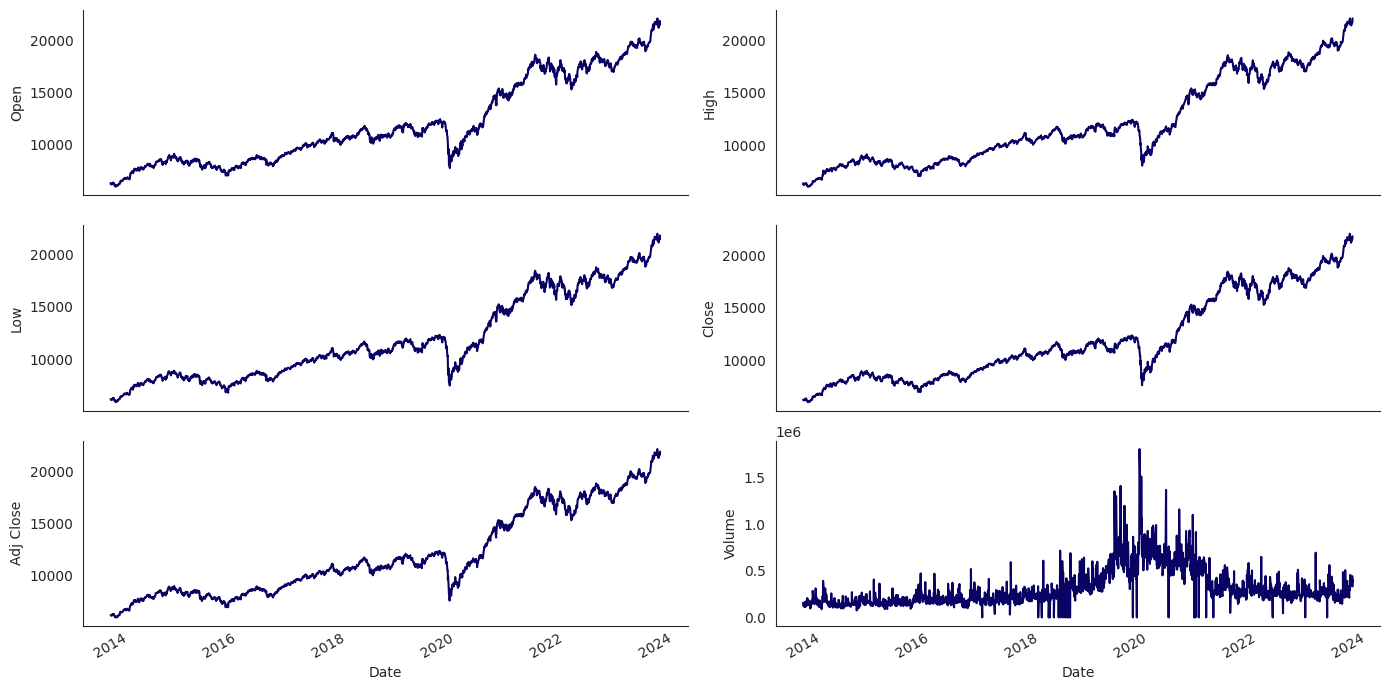

In [67]:
# Plot line charts
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

# Step #3 Preprocessing and Feature Selection

In [68]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
            #, 'Month', 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['High']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2024-01-29,21763.250000,21429.599609,21433.099609,21737.599609,376700,21763.250000
2024-01-30,21813.050781,21501.800781,21775.750000,21522.099609,375100,21813.050781
2024-01-31,21741.349609,21448.849609,21487.250000,21725.699219,410600,21741.349609
2024-02-01,21832.949219,21658.750000,21780.650391,21697.449219,332500,21832.949219
2024-02-02,22126.800781,21805.550781,21812.750000,21853.800781,442800,22126.800781


In [69]:
data_filtered_ext.shape, data_filtered.shape


((2475, 6), (2475, 5))

In [70]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['High'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(2475, 5)


In [71]:
np_data_unscaled.shape,df_Close.shape
df_Close.head()




,High
Date,
2014-01-02,6358.299805
2014-01-03,6221.700195
2014-01-06,6224.700195
2014-01-07,6221.500000
2014-01-08,6192.100098


In [72]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = data.columns.get_loc("High")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(1930, 50, 5) (1930,)
(495, 50, 5) (495,)
0.03519159812237427
0.03519159812237427


In [73]:

data.head

<bound method NDFrame.head of                     Open          High           Low         Close  \
Date                                                                 
2014-01-02   6301.250000   6358.299805   6211.299805   6221.149902   
2014-01-03   6194.549805   6221.700195   6171.250000   6211.149902   
2014-01-06   6220.850098   6224.700195   6170.250000   6191.450195   
2014-01-07   6203.899902   6221.500000   6144.750000   6162.250000   
2014-01-08   6178.049805   6192.100098   6160.350098   6174.600098   
...                  ...           ...           ...           ...   
2024-01-29  21433.099609  21763.250000  21429.599609  21737.599609   
2024-01-30  21775.750000  21813.050781  21501.800781  21522.099609   
2024-01-31  21487.250000  21741.349609  21448.849609  21725.699219   
2024-02-01  21780.650391  21832.949219  21658.750000  21697.449219   
2024-02-02  21812.750000  22126.800781  21805.550781  21853.800781   

               Adj Close  Volume  
Date                    

In [74]:
len(x_train[0]),len(x_train[0][2]),x_train[0][0],x_train[0][0][0]

(50,
 5,
 array([0.02113725, 0.01733545, 0.02192104, 0.01368306, 0.08729983]),
 0.021137251186178707)

In [75]:
y_train.shape

(1930,)

In [76]:
x_train[1][49],x_train[2][49],y_train[0:20]

(array([0.03458628, 0.0351916 , 0.03625201, 0.03204103, 0.09900607]),
 array([0.03249118, 0.03571229, 0.03610014, 0.03250075, 0.09525124]),
 array([0.0351916 , 0.03571229, 0.03367008, 0.03444644, 0.0359929 ,
        0.0381349 , 0.04036419, 0.04154274, 0.04430518, 0.04546504,
        0.04627882, 0.04928134, 0.04761638, 0.04688367, 0.04471674,
        0.04812772, 0.05262993, 0.05050042, 0.0485424 , 0.04563652]))

In [77]:
x_train[0][1], x_train[1], len(x_train[1])


(array([0.01265754, 0.01483804, 0.01530721, 0.01306181, 0.07675318]),
 array([[1.26575441e-02, 1.48380370e-02, 1.53072113e-02, 1.30618057e-02,
         7.67531750e-02],
        [1.28437754e-02, 1.47756793e-02, 1.69374385e-02, 1.18379591e-02,
         6.53230260e-02],
        [1.26451166e-02, 1.31855569e-02, 1.58867783e-02, 1.00238936e-02,
         7.65323026e-02],
        [1.08200560e-02, 1.41583437e-02, 1.42844565e-02, 1.07911449e-02,
         8.11154059e-02],
        [1.05686256e-02, 1.34038089e-02, 1.45107265e-02, 1.04028629e-02,
         8.28823854e-02],
        [1.37376795e-02, 1.28644206e-02, 1.43340628e-02, 1.05954568e-02,
         8.82937604e-02],
        [1.67856710e-02, 1.59791715e-02, 1.49972856e-02, 1.68887190e-02,
         7.45444506e-02],
        [1.62983597e-02, 1.87603329e-02, 1.93796468e-02, 1.49690589e-02,
         6.08503589e-02],
        [1.90825236e-02, 2.07027705e-02, 1.97329742e-02, 1.98800372e-02,
         8.05632247e-02],
        [2.04047536e-02, 2.28572488e-02

# Step #4 Model Training

In [78]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
#model.add(Dropout(0.1)) # new added
#model.add(LSTM(n_neurons, return_sequences=True))# new added
#model.add(LSTM(n_neurons, return_sequences=True))# new added
#model.add(Dropout(0.1))# new added
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

250 50 5


In [79]:
# Training the model
epochs = 60
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                   )

                    #callbacks=[early_stop])

Epoch 1/60
121/121 [==============================] - 5s 16ms/step - loss: 0.0021 - val_loss: 4.0980e-04
Epoch 2/60
121/121 [==============================] - 2s 14ms/step - loss: 2.2400e-04 - val_loss: 4.0282e-04
Epoch 3/60
121/121 [==============================] - 2s 15ms/step - loss: 2.3768e-04 - val_loss: 3.8368e-04
Epoch 4/60
121/121 [==============================] - 2s 18ms/step - loss: 1.8393e-04 - val_loss: 2.9493e-04
Epoch 5/60
121/121 [==============================] - 3s 22ms/step - loss: 1.7037e-04 - val_loss: 5.7638e-04
Epoch 6/60
121/121 [==============================] - 2s 20ms/step - loss: 1.7245e-04 - val_loss: 5.3880e-04
Epoch 7/60
121/121 [==============================] - 2s 17ms/step - loss: 1.7505e-04 - val_loss: 3.8084e-04
Epoch 8/60
121/121 [==============================] - 2s 20ms/step - loss: 1.6229e-04 - val_loss: 9.7045e-04
Epoch 9/60
121/121 [==============================] - 2s 17ms/step - loss: 1.3271e-04 - val_loss: 6.4650e-04
Epoch 10/60
121/121 [==

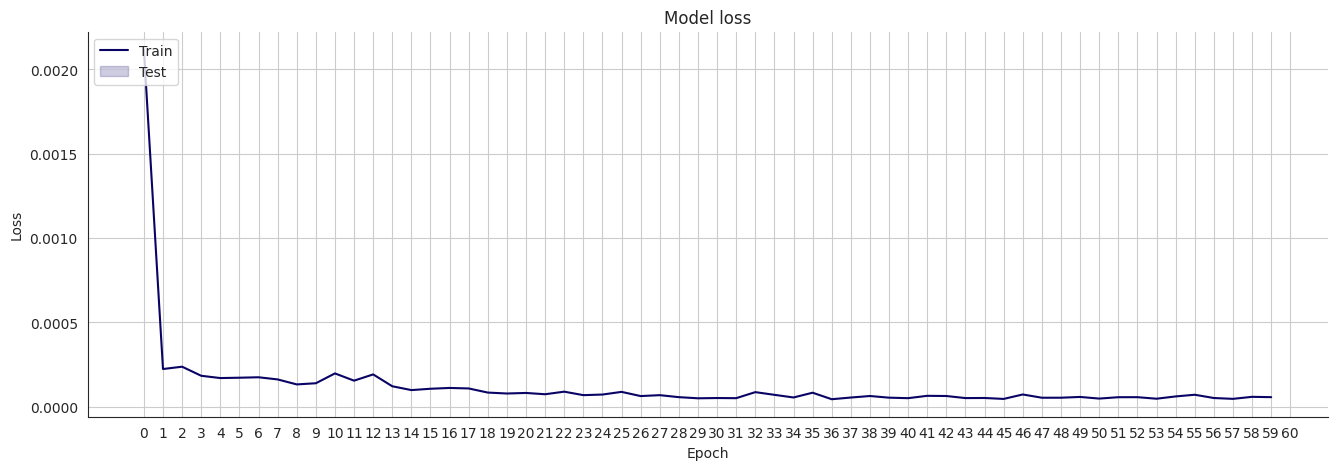

In [80]:
from matplotlib.ticker import FixedLocator

# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
#ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
# Set ticks at every epoch
ax.xaxis.set_major_locator(FixedLocator(range(epochs + 1)))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

# Step #5 Evaluate Model Performance

In [81]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

16/16 [==============================] - 1s 4ms/step
Median Absolute Error (MAE): 119.73
Mean Absolute Percentage Error (MAPE): 0.66 %
Median Absolute Percentage Error (MDAPE): 0.54 %


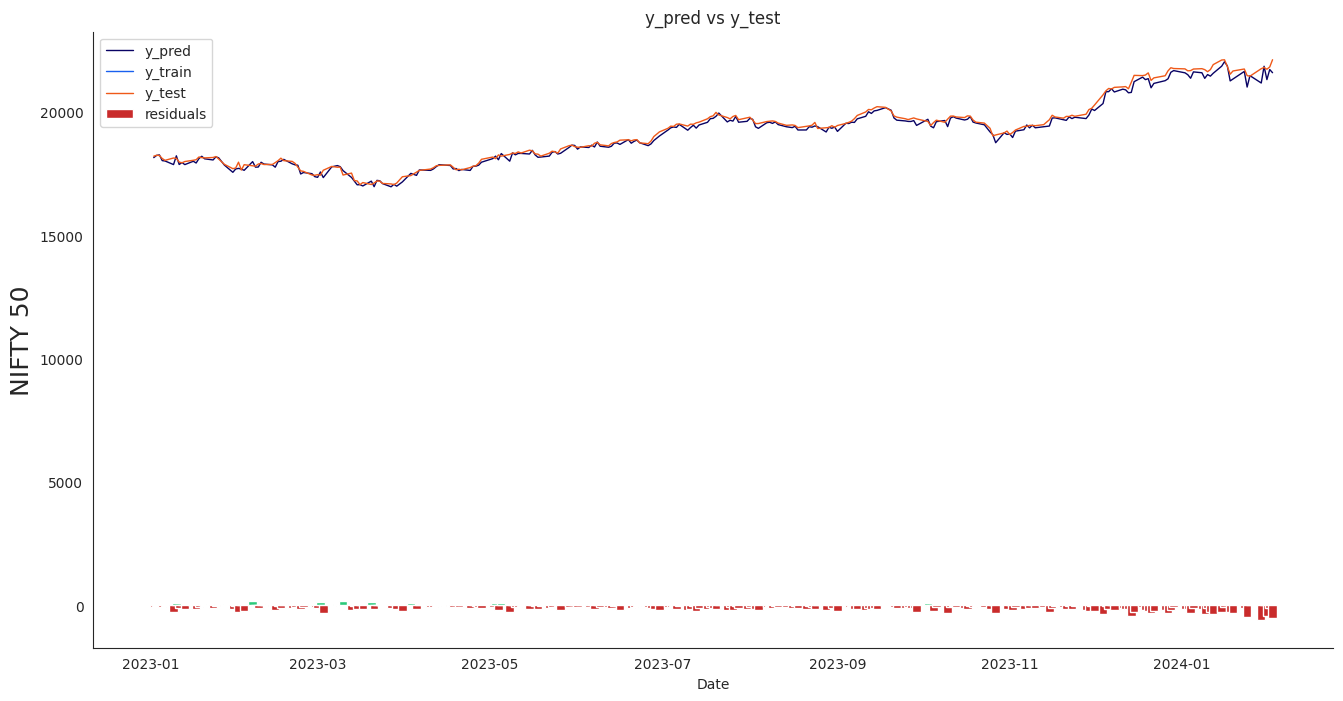

In [84]:
# The date from which on the date is displayed
display_start_date = "2023-01-01"

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['High'][:train_data_len + 1]).rename(columns={'High': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['High'][train_data_len:]).rename(columns={'High': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

# Step #6 Predict Next Day's Price

In [85]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['High'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The high price for {stockname} at {end_date} was {price_today}')
print(f'The predicted high price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 19ms/step
The high price for NIFTY 50 at 2024-02-03 was 22126.8
The predicted high price is 21939.58984375 (-0.85%)
